In [24]:
#!/usr/bin/env python3
"""
Script for processing STARR-seq count matrices and performing library recovery analysis.

This script sets up the environment by importing required modules, configuring paths,
and parsing command-line arguments. It is designed to work with STARR-seq data and includes
options for filtering and region-specific analysis.
"""

# --------------------------------------------------
# Standard Library Imports
# --------------------------------------------------
import os
import sys
import glob
import math
from subprocess import call, PIPE, run, Popen, STDOUT
from multiprocessing import Pool, cpu_count
from random import sample

# --------------------------------------------------
# Third-Party Library Imports
# --------------------------------------------------
import numpy as np
import pandas as pd
import argparse
import pybedtools
import pysam
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Used for advanced subplot layouts
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as clr
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
import scipy
import statsmodels.stats.multitest as smm
from Bio import SeqIO

# --------------------------------------------------
# Matplotlib Configuration
# --------------------------------------------------
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica Neue'

# --------------------------------------------------
# Local Module Imports and Configuration
# --------------------------------------------------
# Dynamically add src directory to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.insert(0, src_path)

import utils
from quality_control import CheckCoverage


In [25]:
# Set the project root directory (assuming current working directory is within a subdirectory)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))


In [43]:
def process_coverage_data(input_path, colormap, query_file_filter=None):
    """
    Reads and processes genome-wide coverage data from a given file, computes additional 
    annotation columns, and filters the data based on query file names.

    Parameters:
        input_path (str): Path to the coverage data file (tab-separated).
        query_file_filter (list, optional): List of query file names to retain.
            Defaults to ['count_mat_no_all_0_sorted_sorted.bed', '10.bed', '20.bed', '50.bed', '100.bed'].

    Returns:
        result_df (pd.DataFrame): Processed coverage DataFrame with added columns:
            - 'filter': Annotation based on the query file name.
            - 'pct': Percentage of genome covered.
            - 'bar_width': Normalized bar width for plotting.
            - 'pct_text': Text formatted percentage.
            - 'text': Combined text showing number of fragments and percentage.
            - 'color': RGBA color values derived from the percentage.
        scalar_mappable: A ScalarMappable object (from matplotlib) used for the colorbar.
    """
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Set a default query file filter if none provided.
    if query_file_filter is None:
        query_file_filter = ['count_mat_no_all_0_sorted_sorted.bed', '10.bed', '20.bed', '50.bed', '100.bed']
    
    # Read the coverage data file.
    coverage_df = pd.read_csv(input_path, sep='\t')
    
    # Simplify the 'Query_file' column to only the filename.
    coverage_df['Query_file'] = coverage_df['Query_file'].apply(lambda x: x.split('/')[-1])
    
    # Generate a filter list for annotation based on the query file name.
    filter_list = []
    for idx in coverage_df.index:
        query_file = coverage_df.loc[idx, 'Query_file']
        if 'count_mat' in query_file or 'umi_' in query_file:
            filter_list.append('All Assayed Regions')
        else:
            cutoff = query_file.split('.bed')[0]
            if 'sum' in cutoff:
                filter_list.append('Count ' + u'$\geq$ ' + cutoff.split('_')[0])
            else:
                filter_list.append('Count ' + u'$\geq$ ' + cutoff)
    coverage_df['filter'] = filter_list
    
    # Calculate the percentage of the genome covered.
    coverage_df['pct'] = coverage_df['num_bp'] / coverage_df['size'] * 100
    
    # Calculate the bar width for plotting: normalize by the first row's fragment count and scale to 10.
    coverage_df['bar_width'] = coverage_df['num_frag'] / coverage_df['num_frag'].iloc[0] * 10
    
    # Create text strings for annotations.
    coverage_df['pct_text'] = coverage_df['pct'].apply(lambda val: "{0:.2f}%".format(val))
    coverage_df['text'] = [
        '{:,}'.format(x) + ' (' + str(y) + ')' for x, y in zip(coverage_df['num_frag'], coverage_df['pct_text'])
    ]
    
    # Create a scalar mappable for color mapping.
    cmap = sns.color_palette(colormap, as_cmap=True)
    norm = plt.Normalize(0, 100)
    scalar_mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    scalar_mappable.set_array([])
    
    # Assign colors based on the percentage coverage.
    coverage_df['color'] = coverage_df['pct'].apply(lambda pct: scalar_mappable.to_rgba(pct)).tolist()
    
    # Filter the DataFrame based on the provided query file filter.
    result_df = coverage_df[coverage_df['Query_file'].isin(query_file_filter)].copy()
    result_df = result_df.reset_index(drop=True)
    
    return result_df, scalar_mappable

def individual_funnel_plot(coverage_result, title, out_path, scalar_mappable, colormap='YlOrBr'):
    """
    Generates a funnel-style horizontal bar plot for the coverage data.

    Parameters:
        coverage_result (pd.DataFrame): Processed coverage DataFrame.
        title (str): Title for the plot.
        out_path (str): Output file path. If empty, the plot is not saved.
        scalar_mappable: ScalarMappable object for the colorbar.
        colormap (str): Name of the colormap (default: 'YlOrBr').

    The plot displays bars representing normalized fragment counts, annotated with text
    and filter labels. A shadow effect is added between consecutive bars.
    """
    import matplotlib.pyplot as plt

    # Create a new figure and axis.
    fig, ax = plt.subplots(figsize=(5, 5))
    
    # Create y-axis positions (sorted in descending order).
    y_positions = sorted(list(range(1, len(coverage_result) + 1)), key=int, reverse=True)
    x_max = 10
    x_min = 0

    # Loop over each row in the coverage data to plot the bars.
    for idx in range(len(coverage_result)):
        # Calculate the left offset to center the bar horizontally.
        left_offset = (x_max - coverage_result.bar_width.iloc[idx]) / 2
        ax.barh(y_positions[idx], coverage_result.bar_width.iloc[idx],
                left=left_offset, color=coverage_result.color.iloc[idx], alpha=1)
        
        # Choose text color based on the percentage value.
        text_color = '#f7f7f7' if coverage_result.pct.iloc[idx] > 85 else '#252525'
        
        # Annotate the bar with fragment count and percentage text.
        ax.text(5, y_positions[idx] - 0.1, coverage_result.text.iloc[idx],
                ha='center', fontsize=17, color=text_color)
        
        # Annotate the left side with the filter label.
        ax.text(-2, y_positions[idx], coverage_result['filter'].iloc[idx],
                ha='right', fontsize=17, color='#252525')
        
        # Draw a connecting shadow between consecutive bars.
        if idx != len(coverage_result) - 1:
            next_left_offset = (x_max - coverage_result.bar_width.iloc[idx + 1]) / 2
            shadow_x = [left_offset, next_left_offset, x_max - next_left_offset, x_max - left_offset, left_offset]
            shadow_y = [y_positions[idx] - 0.4, y_positions[idx + 1] + 0.4,
                        y_positions[idx + 1] + 0.4, y_positions[idx] - 0.4, y_positions[idx] - 0.4]
            ax.fill(shadow_x, shadow_y, color='#d9d9d9', alpha=0.6)
    
    # Set axis limits and remove axis lines.
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0.5, len(coverage_result) + 0.5)
    ax.axis('off')

    # Set the plot title.
    plt.title(title, loc='center', fontsize=20, color='#252525')
    
    # Add a vertical colorbar using the provided scalar mappable.
    cb = fig.colorbar(scalar_mappable, ax=ax, orientation='vertical', pad=0.1, fraction=0.05)
    cb.ax.set_yticklabels(["{0:.0f}%".format(val * 100) for val in [0, 0.2, 0.4, 0.6, 0.8, 1.0]], fontsize=17)
    
    # Save the plot if an output path is provided.
    if out_path:
        plt.savefig(out_path, bbox_inches='tight', transparent=True, dpi=300)
    else:
        plt.show()



Number of filtered entries: 5


<ipython-input-43-85c9346634c4>:137: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{0:.0f}%".format(val * 100) for val in [0, 0.2, 0.4, 0.6, 0.8, 1.0]], fontsize=17)


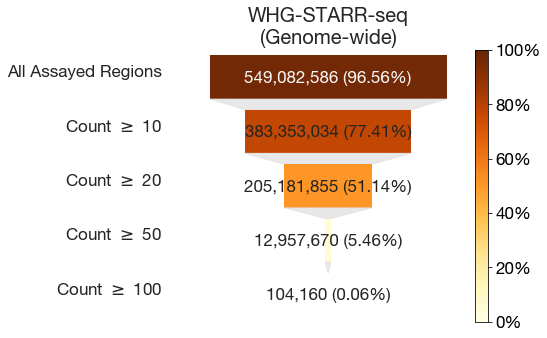

In [44]:
# =============================================================================
# WHG-STARR-seq
# =============================================================================
# Define the data path for the WHG-STARR-seq genome-wide coverage file.
data_path = os.path.join(project_root, 'data', 'qc', 'assay_coverage', 'WHG_STARR_seq', 'genome_wide_coverage_df.txt')

# Process the coverage data and obtain the processed DataFrame and scalar mappable.
selected_files = ['count_mat_no_all_0_sorted_sorted.bed', '10.bed', '20.bed', '50.bed', '100.bed']
coverage_result_df, scalar_mappable = process_coverage_data(data_path, 'YlOrBr', query_file_filter=selected_files)

# Optionally, filter the processed DataFrame based on specific query file names.
result_df = coverage_result_df[coverage_result_df['Query_file'].isin(selected_files)].reset_index(drop=True)
print("Number of filtered entries:", len(result_df))

# Generate the funnel plot for the selected coverage data.
individual_funnel_plot(result_df, 'WHG-STARR-seq\n(Genome-wide)', '', scalar_mappable, colormap='YlOrBr')


Number of filtered entries: 5


<ipython-input-43-85c9346634c4>:137: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{0:.0f}%".format(val * 100) for val in [0, 0.2, 0.4, 0.6, 0.8, 1.0]], fontsize=17)


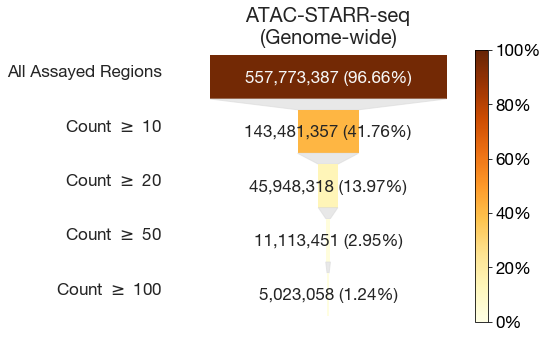

In [45]:
# =============================================================================
# ATAC-STARR-seq
# =============================================================================
# Define the data path for the ATAC-STARR-seq genome-wide coverage file.
data_path = os.path.join(project_root, 'data', 'qc', 'assay_coverage', 'ATAC_STARR_seq', 'genome_wide_coverage_df.txt')

# Process the coverage data and obtain the processed DataFrame and scalar mappable.
selected_files = ['count_mat_no_all_0_sorted.bed', '10.bed', '20.bed', '50.bed', '100.bed']
coverage_result_df, scalar_mappable = process_coverage_data(data_path, 'YlOrBr', query_file_filter=selected_files)

# Optionally, filter the processed DataFrame based on specific query file names.
result_df = coverage_result_df[coverage_result_df['Query_file'].isin(selected_files)].reset_index(drop=True)
print("Number of filtered entries:", len(result_df))

# Generate the funnel plot for the selected coverage data.
individual_funnel_plot(result_df, 'ATAC-STARR-seq\n(Genome-wide)', '', scalar_mappable, colormap='YlOrBr')


Number of filtered entries: 5


<ipython-input-43-85c9346634c4>:137: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{0:.0f}%".format(val * 100) for val in [0, 0.2, 0.4, 0.6, 0.8, 1.0]], fontsize=17)


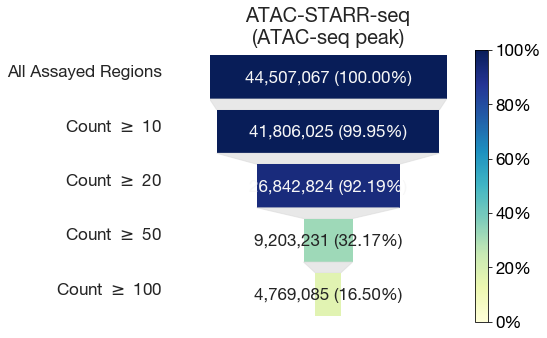

In [49]:
# =============================================================================
# ATAC-STARR-seq
# =============================================================================
reference = 'KS91_K562_hg38_ASTARRseq_Input.all_reps.masked.union_narrowPeak.q5.bed'

# Define the data path for the ATAC-STARR-seq open-region coverage file.
data_path = os.path.join(project_root, 'data', 'qc', 'assay_coverage', 'ATAC_STARR_seq', 'region_coverage_df.txt')

# Process the coverage data and obtain the processed DataFrame and scalar mappable.
selected_files = ['count_mat_no_all_0_atac_peak_q5_1bp_deduplicated_sorted.bed', '10.bed', '20.bed', '50.bed', '100.bed']
coverage_result_df, scalar_mappable = process_coverage_data(data_path, 'YlGnBu', query_file_filter=selected_files)

# Optionally, filter the processed DataFrame based on specific query file names.
result_df = coverage_result_df[coverage_result_df['Query_file'].isin(selected_files)].reset_index(drop=True)
result_df = coverage_result_df[coverage_result_df['region'].map(lambda x: reference in x)]
print("Number of filtered entries:", len(result_df))

# Generate the funnel plot for the selected coverage data.
individual_funnel_plot(result_df, 'ATAC-STARR-seq\n(ATAC-seq peak)', '', scalar_mappable, colormap='YlGnBu')


Number of filtered entries: 5


<ipython-input-43-85c9346634c4>:137: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(["{0:.0f}%".format(val * 100) for val in [0, 0.2, 0.4, 0.6, 0.8, 1.0]], fontsize=17)


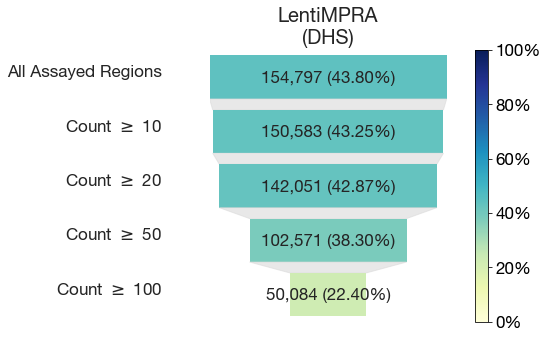

In [51]:
# =============================================================================
# LentiMPRA
# =============================================================================
reference = 'ENCFF185XRG.bed.gz'

# Define the data path for the ATAC-STARR-seq open-region coverage file.
data_path = os.path.join(project_root, 'data', 'qc', 'assay_coverage', 'LentiMPRA', 'region_coverage_df.txt')

# Process the coverage data and obtain the processed DataFrame and scalar mappable.
selected_files = ['processed_umi_umi_genomic_elemnets_only_sorted.bed', '10.bed', '20.bed', '50.bed', '100.bed']
coverage_result_df, scalar_mappable = process_coverage_data(data_path, 'YlGnBu', query_file_filter=selected_files)

# Optionally, filter the processed DataFrame based on specific query file names.
result_df = coverage_result_df[coverage_result_df['Query_file'].isin(selected_files)].reset_index(drop=True)
result_df = coverage_result_df[coverage_result_df['region'].map(lambda x: reference in x)]
print("Number of filtered entries:", len(result_df))

# Generate the funnel plot for the selected coverage data.
individual_funnel_plot(result_df, 'LentiMPRA\n(DHS)', '', scalar_mappable, colormap='YlGnBu')

